# HW №1
## Task 1

In [1]:
%%capture
!pip3 install qiskit

In [2]:
import numpy as np
import qiskit as qk

In [3]:
with open('./token', 'r') as token_file:
    token = token_file.read()

In [4]:
qk.IBMQ.save_account(token, overwrite = True)
qk.IBMQ.load_account()

/usr/local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = qk.IBMQ.get_provider(hub = 'ibm-q')

In [6]:
devices = provider.backends(filters=lambda x: (3 <= x.configuration().n_qubits <= 5) and not x.configuration().simulator)

In [7]:
real_backend = qk.providers.ibmq.least_busy(devices)
print(real_backend.configuration().n_qubits)

5


In [8]:
simd_backend = qk.Aer.get_backend('qasm_simulator')

## Task 2

Since we assume the following form of QBit wavefunction:
$\vert \psi \rangle = \sin \theta \vert 0 \rangle + \exp{i\varphi} \cos \theta \vert 1 \rangle$

We can transform basis into:

$$
\begin{align}
    \vert + \rangle = \frac{1}{\sqrt 2} \left( \vert 0 \rangle + \vert 1 \rangle \right); & &
        \vert 0 \rangle = \frac{1}{\sqrt 2} \left( \vert + \rangle + \vert - \rangle \right);\\
    \vert - \rangle = \frac{1}{\sqrt 2} \left( \vert 0 \rangle - \vert 1 \rangle \right); & &
        \vert 1 \rangle = \frac{1}{\sqrt 2} \left( \vert + \rangle - \vert - \rangle \right);
\end{align}
$$

In this basis:
$\vert \psi \rangle = \frac{\sin \theta + e^{i\varphi} \cos \theta}{\sqrt 2} \vert + \rangle + 
                      \frac{\sin \theta - e^{i\varphi} \cos \theta}{\sqrt 2} \vert - \rangle; $

In [125]:
q = qk.QuantumRegister(2)
c = qk.ClassicalRegister(2)
qc = qk.QuantumCircuit(q, c)

In [126]:
qc.initialize([np.sqrt(15.) / 4., 1. / 4.], q[0])
qc.h(q[1])
qc.swap(q[0], q[1])
#qc.unitary(to_basis, [0])
#qc.unitary(to_basis, [1])
qc.measure(q, c)

In [127]:
qc.draw()

┌──────────────────────────┐   ┌─┐   
q83_0: ┤ initialize(0.96825,0.25) ├─X─┤M├───
       └──────────┬───┬───────────┘ │ └╥┘┌─┐
q83_1: ───────────┤ H ├─────────────X──╫─┤M├
                  └───┘                ║ └╥┘
c10: 2/════════════════════════════════╩══╩═
                                       0  1

In [128]:
res = qk.execute(qc, backend = simd_backend, shots = 16384).result()

In [129]:
r = res.get_counts()
print(r)

{'00': 7617, '01': 7691, '10': 541, '11': 535}


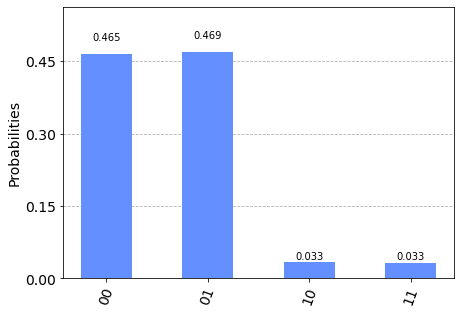

In [130]:
qk.visualization.plot_histogram(res.get_counts(qc))

In [131]:
alpha = (r['00'] + r['01']) / (r['10'] + r['11'])

In [132]:
alpha

14.226765799256505

In [108]:
beta = (r['00'] + r['10']) / (r['01'] + r['11'])

In [109]:
beta

0.987867022567338

In [ ]:
tan